In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import librosa
from librosa import display
import IPython.display as ipd
audio_dir='/content/drive/MyDrive/Colab Notebooks/Audio/'
audio_dir_new='/content/drive/MyDrive/Colab Notebooks/Audio_new/'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Creating Dataset

In [4]:
def get_filename(dir_name):
  filenames_list=[]
  for entry in os.scandir(dir_name):
     if (entry.path.endswith(".wav") and entry.is_file()):
      filenames_list.append(entry.name)
  return filenames_list

def get_subfolders(dir_name):
  dirlist=[]
  for item in os.listdir(dir_name):
    if os.path.isdir(item):
        dirlist.append(item)
  return dirlist

def Audio_to_tensor(dir_name):
  os.chdir(dir_name)
  print(dir_name)
  X=[]
  folder_list=get_subfolders(dir_name)
  avance=1
  for folder in folder_list:
    print("Treating folder",avance,"out of",np.size(folder_list))
    avance=avance+1
    filename_list=get_filename(dir_name+'/'+folder)
    os.chdir(dir_name+'/'+folder)
    for file in filename_list:
      S,sr=librosa.load(dir_name+'/'+folder+'/'+file)
      sf=librosa.feature.mfcc(S,n_mfcc=128,sr=44100)
      X.append(sf)
  X=np.array(X)
  tensor=tf.convert_to_tensor(X,dtype=tf.float32)
  print("Done !")
  return tensor

In [ ]:
X=Audio_to_tensor(audio_dir+'X_train')
y=Audio_to_tensor(audio_dir_new+'y_train')
X_valid=Audio_to_tensor(audio_dir+'X_valid')
y_valid=Audio_to_tensor(audio_dir_new+'y_valid')

In [54]:
input_shape = X.shape[1:]

print("Input shape: {}".format(input_shape))

Input shape: (128, 9)


#CNN

## Configuration of our CNN

In [55]:
from tensorflow.keras import callbacks
early_stopping=callbacks.EarlyStopping(
    patience=15,
    min_delta=0.0001,
    restore_best_weights=True
)

In [65]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([          
        layers.Conv1D(1024, 3,padding="same",activation='relu',input_shape=input_shape),
        layers.MaxPool1D(2,data_format='channels_first'),
        layers.Conv1D(512, 3,padding="same",activation='relu',input_shape=input_shape),
        layers.MaxPool1D(2,data_format='channels_first'),
        layers.Conv1D(256, 3,padding="same",activation='relu',input_shape=input_shape),
        layers.MaxPool1D(2,data_format='channels_first'),
        layers.Conv1D(128, 3,padding="same",activation='relu',input_shape=input_shape),
        layers.MaxPool1D(2,data_format='channels_first'),
        layers.Conv1D(64, 3,padding="same",activation='relu',input_shape=input_shape),
        layers.MaxPool1D(2,data_format='channels_first'),
        layers.Conv1D(32, 3,padding="same",activation='relu',input_shape=input_shape),
        layers.MaxPool1D(2,data_format='channels_first'),
        layers.Conv1D(18, 3,padding="same",activation='relu',input_shape=input_shape),
        layers.MaxPool1D(2,data_format='channels_first'),
        layers.Dense(units=9)
        #tf.keras.layers.MaxPooling1D(pool_size=2, padding='valid'),
        ])

model.compile(
    optimizer = 'Adam',
    loss = 'mse',)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 128, 1024)         28672     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 512)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 128, 512)          786944    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 256)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 128, 256)          196864    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 128, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 128, 128)         

## Training of our model

Minimum Validation Loss: 36.1932


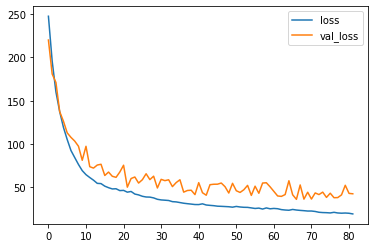

In [66]:
history = model.fit(
    X, y,
    validation_data=(X_valid,y_valid),
    batch_size=64,
    epochs=1500,
    callbacks=[early_stopping],
    #verbose=False
)
# Start the plot at epoch 10
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

##Results

We tried to make a prediction using our validation data. This works very well but it could be related to the fact that our validation data is very close to our training data.

In [67]:
y_predict=model.predict(X_valid)

### Visualizing our predictions

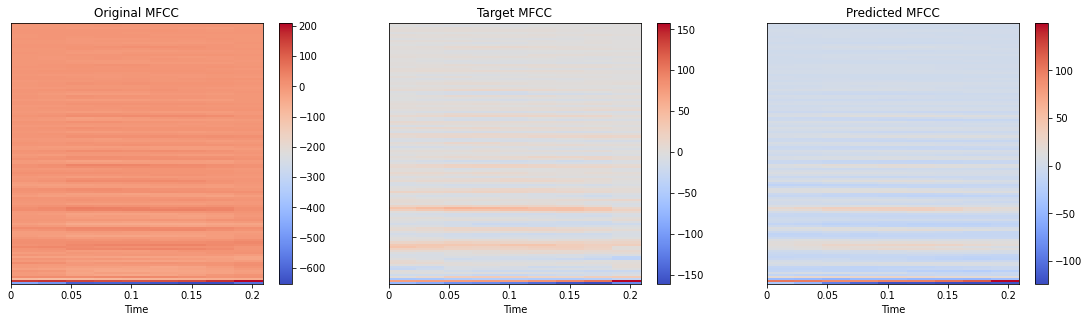

In [74]:
plt.figure(figsize=[3*6.4,4.8])
plt.subplot(1,3,1)
librosa.display.specshow(X_valid.numpy()[180],x_axis='time')
plt.colorbar()
plt.title("Original MFCC")
plt.subplot(1,3,2)
librosa.display.specshow(y_valid.numpy()[180],x_axis='time')
plt.title("Target MFCC")
plt.colorbar()
plt.subplot(1,3,3)
librosa.display.specshow(y_predict[180],x_axis='time')
plt.title("Predicted MFCC")
plt.colorbar()

### Listening to the predicitions :


In [69]:
predicted_audio=[]
for i in range (y_predict.shape[0]):
  predicted_audio=np.append(predicted_audio,librosa.feature.inverse.mfcc_to_audio(y_predict[i], sr=44100,n_mels=128, dct_type=2, norm='ortho', ref=1.0, lifter=0))
target_audio=[]
for i in range (y_predict.shape[0]):
  target_audio=np.append(target_audio,librosa.feature.inverse.mfcc_to_audio(y_valid.numpy()[i], sr=44100,n_mels=128, dct_type=2, norm='ortho', ref=1.0, lifter=0))
original_audio=[]
for i in range(X_valid.shape[0]):
  original_audio=np.append(original_audio,librosa.feature.inverse.mfcc_to_audio(X_valid.numpy()[i], sr=44100,n_mels=128, dct_type=2, norm='ortho', ref=1.0, lifter=0))

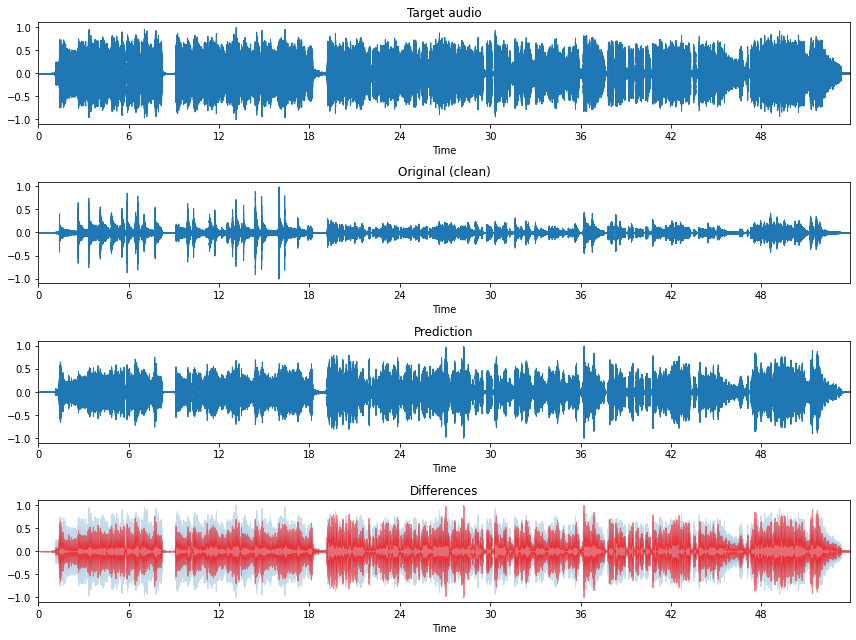

In [70]:
target_audio=librosa.util.normalize(target_audio)
predicted_audio=librosa.util.normalize(predicted_audio)
original_audio=librosa.util.normalize(original_audio)
plt.figure(figsize=[12,9])
plt.subplot(4,1,1)
librosa.display.waveplot(target_audio,sr=22050)
plt.title("Target audio")
plt.subplot(4,1,2)
librosa.display.waveplot(original_audio,sr=22050)
plt.title("Original (clean)")
plt.subplot(4,1,3)
librosa.display.waveplot(predicted_audio,sr=22050)
plt.title("Prediction")
plt.subplot(4,1,4)
librosa.display.waveplot(target_audio,sr=22050,alpha=0.25)
librosa.display.waveplot(predicted_audio,sr=22050,alpha=0.5,color='r')
plt.title("Differences")
plt.tight_layout()

In [75]:
ipd.Audio(original_audio,rate=22050)

In [71]:
ipd.Audio(predicted_audio,rate=22050,)

Despite the fact that MFCC degrade our audio signal a lot, we can hear and see thta our predictions are very close to our targets.  
We will try other approachs with our CNN, mainly using STFT and maybe the raw audio to make cleaner predictions